In [1]:
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import collections

In [2]:
# extract character from single image
def extract_ch(image_input_dir, file_name, img_output_dir = None, label_counts = None, 
               margin = None, plot = None, wr_ratio_threshold = None, return_character = None):
    # setting defult parm    
    # additional margin for output image
    margin = margin if margin else 2
    # ploting input and output image
    plot = plot if plot else False
    # threshold for separating multiple characters in one contour based on width height ratio
    wr_ratio_threshold = wr_ratio_threshold if wr_ratio_threshold else 1.25
    # if True return character image extracted from given image
    return_character = return_character if return_character else False
    
    # get labels
    labels = [s for s in file_name if s not in ".png"]
    # read image in grey scale
    grey = cv2.imread(image_input_dir+"/"+file_name, 0)
    if plot:
        ploting_img = [grey]
        ploting_titles = ["original image"]
    # add frame
    white = [255,255,255]
    grey = cv2.copyMakeBorder(grey, 4*margin, 4*margin, 4*margin, 4*margin, cv2.BORDER_CONSTANT, value = white)
    # Adaptive Thresholding
    # Converting color to only black and white
    th = cv2.adaptiveThreshold(grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

    # find contours
    th1, contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    letters = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        # separate contour based on width height ratio
        wh_ratio = w/h 
        n_chr = math.ceil(wh_ratio/wr_ratio_threshold)
        letters += [(x+i*int(w/n_chr), int(y), int(w/n_chr)+1, int(h)) for i in range(n_chr)]
    # return finded contour
    if return_character:
        res = []
        for letter_rectangle in sorted(letters, key = lambda x:x[0]) :
            x, y, w, h = letter_rectangle
            # add margin
            res.append(th[y-margin:y+h+margin, x-margin:x+w+margin])
        return res
    # separate success or not   
    separation = (len(letters) == len(labels))    
    if separation:
        letters = sorted(letters, key = lambda x:x[0]) 
        for letter_rectangle, letter_label in zip(letters, labels):
            x, y, w, h = letter_rectangle
            # add margin
            letter_img = th[y-margin:y+h+margin, x-margin:x+w+margin]
            if plot:
                ploting_img.append(letter_img)
                ploting_titles.append(letter_label)
            # output letter image
            if img_output_dir:
                p = "{}/{}_{}.png".format(img_output_dir,letter_label,label_counts[letter_label])
                cv2.imwrite(p, letter_img)
                label_counts[letter_label] += 1
    else:
        if plot:
            letters = sorted(letters, key = lambda x:x[0]) 
            for letter_rectangle in letters:
                x, y, w, h = letter_rectangle
                # add margin
                letter_img = th[y-margin:y+h+margin, x-margin:x+w+margin]
                ploting_img.append(letter_img)
        else:
            return False
    
    #plot the result
    if plot:
        plt.imshow(ploting_img[0], cmap = 'gray',interpolation = 'bicubic')
        plt.title(ploting_titles[0])
        plt.show()
        for i in range(1, len(ploting_img)):
            plt.subplot(1,len(ploting_img),i)
            plt.imshow(ploting_img[i],'gray')
            if len(letters) == len(labels):
                plt.title(ploting_titles[i])
            plt.xticks([]),plt.yticks([])
        plt.show()
    
    return separation

192 failures


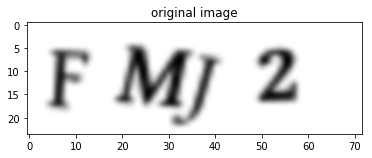

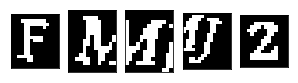

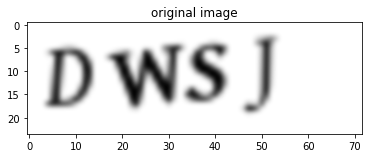

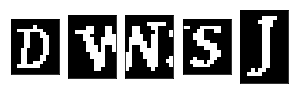

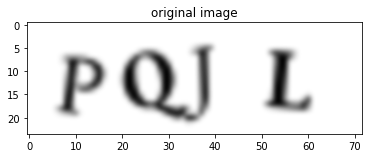

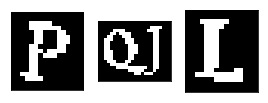

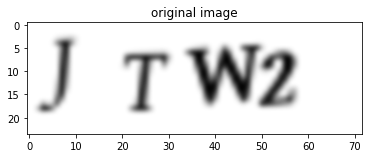

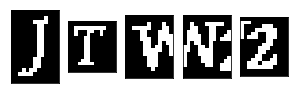

In [3]:
# cv2.__version__
# This script is test on version 3.3.0
if __name__ == "__main__":
    img_input_dir = os.path.dirname(os.getcwd()) + "/wordpress"
    img_output_dir = os.path.dirname(os.getcwd()) + "/training_data"
    if not os.path.exists(img_output_dir):
        os.makedirs(img_output_dir)
    label_counts = collections.defaultdict(int)
    failures = []
    with os.scandir(img_input_dir) as it:
        for f in it:
            if f.name.endswith(".png"):
                success = extract_ch(img_input_dir, f.name, img_output_dir, label_counts)
                if not success:
                    failures.append(f.name)
    print("{} failures".format(len(failures)))
    if failures:
        with open('failures.txt', 'a') as the_file:
            for failure in failures:
                the_file.write(str(failure)+'\n')
    # Analyzing failures samples
    extract_ch(img_input_dir, "FMJ2.png", plot = True)
    extract_ch(img_input_dir, "DWSJ.png", plot = True)
    extract_ch(img_input_dir, "PQJL.png", plot = True)
    extract_ch(img_input_dir, "JTW2.png", plot = True)